In [1]:
from chemprop import data, featurizers, utils
import pandas as pd
import torch
import numpy as np
from lightning import pytorch as pl
new_mols = pd.read_csv('new-mol-data.csv')
new_smiles = new_mols['SMILES']
test_mols = [utils.make_mol(new, keep_h=False, add_h=False) for new in new_smiles]
test_feats = np.array(new_mols.iloc[:,2:])
test_data = [
    data.MoleculeDatapoint(mol, V_f=None, E_f=None, V_d=None ,x_d=X_d)
    for mol, X_d in zip(
        test_mols,
        test_feats,
    )
]

featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()
test_dset = data.MoleculeDataset(test_data, featurizer=featurizer)
test_loader = data.build_dataloader(test_dset, shuffle=False)
model = torch.load('mpnn_v2.ckpt')
with torch.inference_mode():
    trainer = pl.Trainer(
        logger=None,
        enable_progress_bar=True,
        accelerator="gpu",
        devices=1
    )
    test_preds = trainer.predict(model, test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
d:\anaconda3\envs\chemprop2\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_p

Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.38it/s]


In [2]:
test_preds = np.concatenate(test_preds, axis=0)
new_mols['pred'] = test_preds
new_mols[['SMILES',	'NAME',	'pred']]

,SMILES,NAME,pred
0,O=P(O)(O)CCN1c2ccccc2Sc2ccccc21,PAPZ,24.738579
1,O=P(O)(O)CCN1c2ccccc2S(=O)(=O)c2ccccc21,PAPZO,25.703407


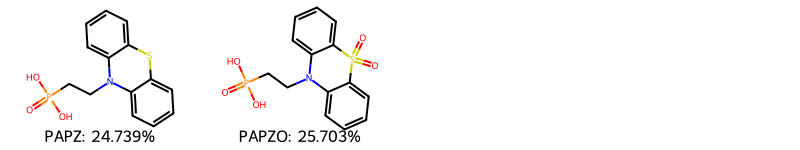

In [3]:
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
mols =[Chem.MolFromSmiles(smi) for smi in new_mols['SMILES']]
legends = [f'{name}: {pred:.3f}%' for name, pred in zip(new_mols['NAME'], new_mols['pred'])]
MolsToGridImage(mols,subImgSize=(200,150),molsPerRow=4,legends=legends)